<a href="https://colab.research.google.com/github/google/tunix/blob/main/examples/qlora_demo.ipynb" ><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install necessary libraries

In [ ]:
!pip install -q kagglehub

!pip install -q tensorflow
!pip install -q tensorboardX
!pip install -q grain
!pip install -q datasets
!pip install -q git+https://github.com/google/tunix
!pip install -q git+https://github.com/google/qwix

!pip uninstall -q -y flax
!pip install -q git+https://github.com/google/flax.git

In [ ]:
# If you want to upload your metrics to Weights & Biases, please install the package and login. Make sure to install `wandb` before importing `tunix`.
!pip install wandb

import wandb
wandb.login()

If `wandb` is installed, you'll see a message like the one below when you start the experiment:

```
Tracking run with wandb version 0.21.0
Run data is saved locally in /content/wandb/run-20250717_224322-kmvoi0ho
Syncing run 2025-07-17_22-43-22 to Weights & Biases (docs)
View project at https://wandb.ai/<wandb_username>/tunix?apiKey=<api_key>
View run at https://wandb.ai/<wandb_username>/tunix/runs/kmvoi0ho?apiKey=<api_key>
Do NOT share these links with anyone. They can be used to claim your runs.
```

After clicking the link, you will be directed to the following Weights & Biases metrics page which contain train metrics, eval metrics, system metrics, and various custom metric you wish to report:

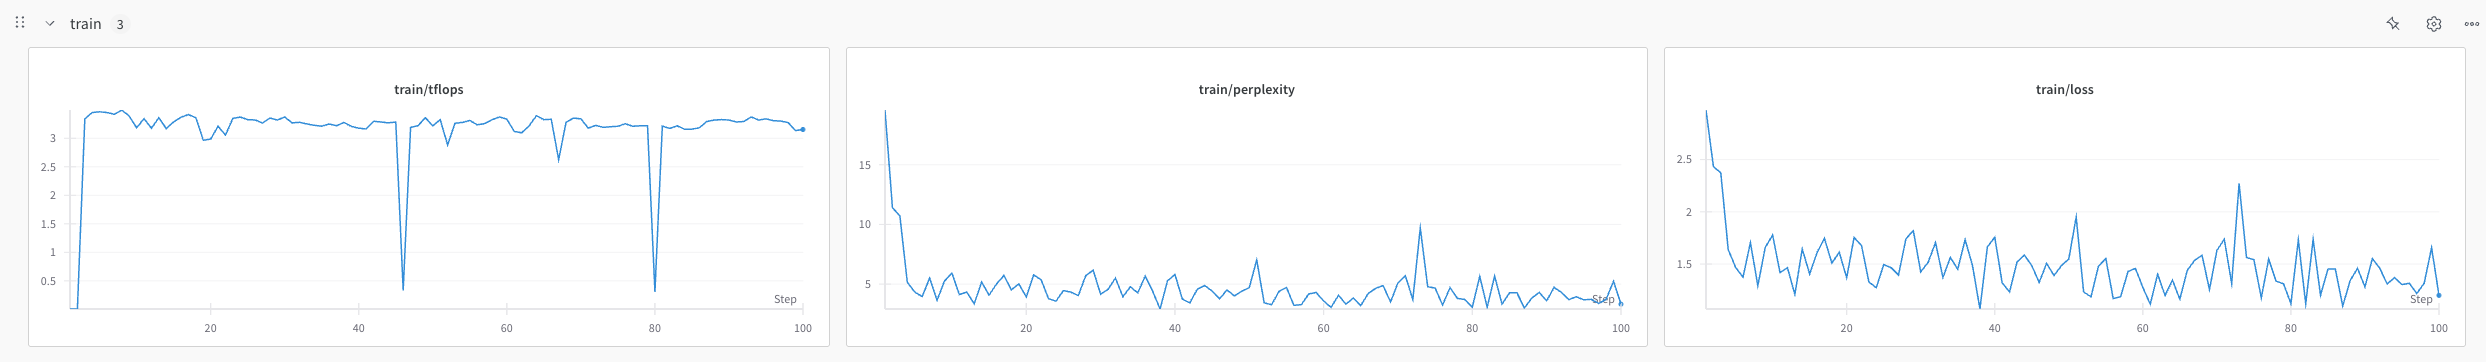

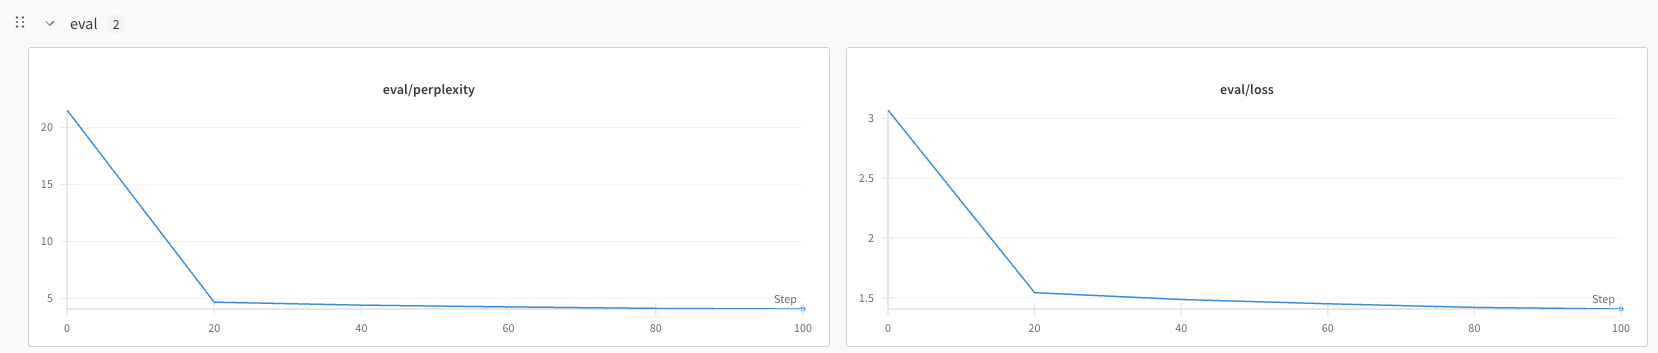

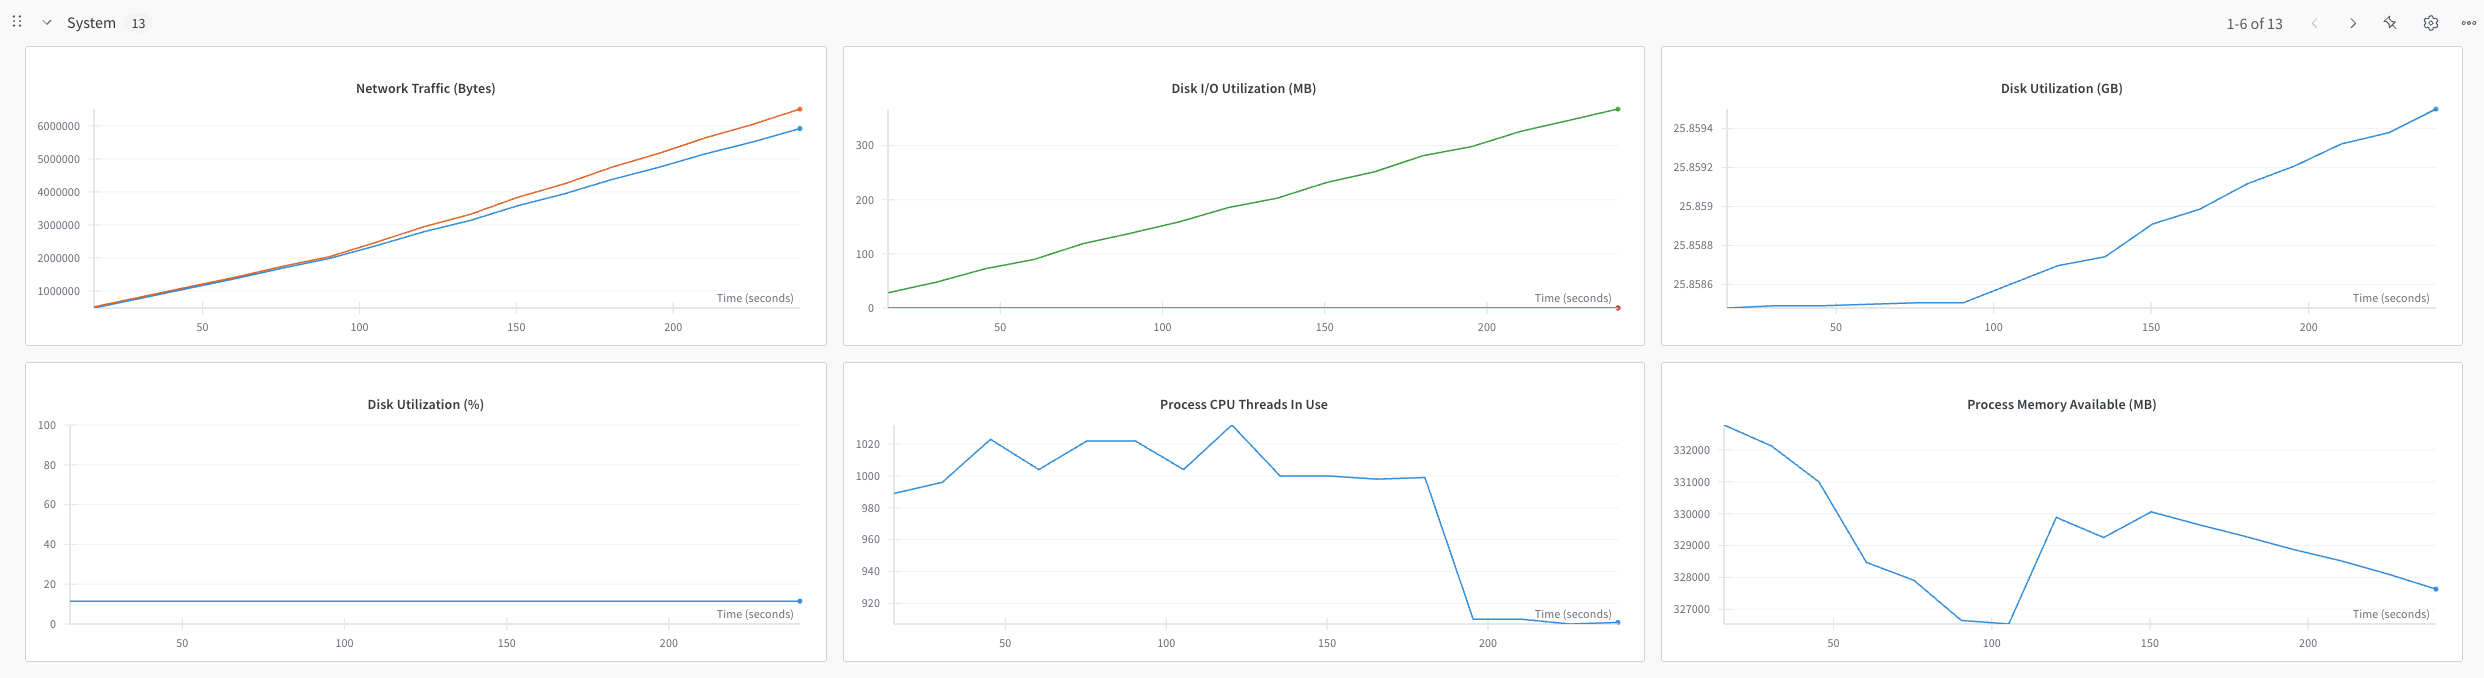

## Imports

In [ ]:
import gc
import os
import time

from flax import nnx
import jax
import jax.numpy as jnp
import kagglehub
import optax
from orbax import checkpoint as ocp
from qwix import lora
from tunix.generate import sampler as sampler_lib
from tunix.models.gemma import data as data_lib
from tunix.models.gemma import gemma as gemma_lib
from tunix.models.gemma import params as params_lib
from tunix.sft import metrics_logger
from tunix.sft import peft_trainer

## Hyperparameters

In [ ]:
# Data
BATCH_SIZE = 16

# Model
MESH = [(1, 8), ("fsdp", "tp")]
# LoRA
RANK = 16
ALPHA = 2.0

# Train
MAX_STEPS = 100
EVAL_EVERY_N_STEPS = 20
NUM_EPOCHS = 3


# Checkpoint saving
INTERMEDIATE_CKPT_DIR = "/content/intermediate_ckpt/"
CKPT_DIR = "/content/ckpts/"
PROFILING_DIR = "/content/profiling/"

## Load Gemma 2B

To load the model, you need to be on [Kaggle](https://www.kaggle.com/) and need
to have agreed to the Gemma license
[here](https://www.kaggle.com/models/google/gemma/flax/).

In [ ]:
# Log in
if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
  kagglehub.login()

In [ ]:
kaggle_ckpt_path = kagglehub.model_download("google/gemma/flax/2b")

In [ ]:
# This is a workaround. The checkpoints on Kaggle don't work with NNX. So, we
# load the model, save the checkpoint locally, and then reload the model
# (sharded).
params = params_lib.load_and_format_params(os.path.join(kaggle_ckpt_path, "2b"))
gemma = gemma_lib.Transformer.from_params(params, version="2b")
checkpointer = ocp.StandardCheckpointer()
_, state = nnx.split(gemma)
checkpointer.save(os.path.join(INTERMEDIATE_CKPT_DIR, "state"), state)

In [ ]:
# Wait for the ckpt to save successfully.
time.sleep(60)

In [ ]:
# Delete the intermediate model to save memory.
del params
del gemma
del state
gc.collect()

In [ ]:
def get_base_model(ckpt_path):

  model_config = gemma_lib.TransformerConfig.gemma_2b()
  mesh = jax.make_mesh(*MESH)
  abs_gemma: nnx.Module = nnx.eval_shape(
      lambda: gemma_lib.Transformer(model_config, rngs=nnx.Rngs(params=0))
  )
  abs_state = nnx.state(abs_gemma)
  abs_state = jax.tree.map(
      lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
      abs_state,
      nnx.get_named_sharding(abs_state, mesh),
  )
  checkpointer = ocp.StandardCheckpointer()
  restored_params = checkpointer.restore(ckpt_path, target=abs_state)

  graph_def, _ = nnx.split(abs_gemma)
  gemma = nnx.merge(graph_def, restored_params)
  return gemma, mesh, model_config

In [ ]:
# Base model
gemma, mesh, model_config = get_base_model(
    ckpt_path=os.path.join(INTERMEDIATE_CKPT_DIR, "state")
)
nnx.display(gemma)

## Prompt the model

Let's see how the model performs on the English-French translation task.

In [ ]:
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

sampler = sampler_lib.Sampler(
    transformer=gemma,
    tokenizer=gemma_tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    total_generation_steps=10,  # The number of steps performed when generating a response.
)

for input_string, out_string in zip(input_batch, out_data.text):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")

## Apply LoRA/QLoRA to the model

In [ ]:
def get_lora_model(base_model, mesh):
  lora_provider = lora.LoraProvider(
      module_path=".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj",
      rank=RANK,
      alpha=ALPHA,
      # comment the two args below for LoRA (w/o quantisation).
      weight_qtype="nf4",
      tile_size=256,
  )

  model_input = base_model.get_model_input()
  lora_model = lora.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

In [ ]:
# LoRA model
lora_gemma = get_lora_model(gemma, mesh=mesh)
nnx.display(lora_gemma)

## Load Datasets for SFT Training

In [ ]:
# Loads the training and validation datasets
train_ds, validation_ds = data_lib.create_datasets(
    dataset_name='mtnt/en-fr',
    # Uncomment the line below to use a Hugging Face dataset.
    # Note that this requires upgrading the 'datasets' package and restarting
    # the Colab runtime.
    # dataset_name='Helsinki-NLP/opus-100',
    global_batch_size=BATCH_SIZE,
    max_target_length=256,
    num_train_epochs=NUM_EPOCHS,
    tokenizer=gemma_tokenizer,
)


def gen_model_input_fn(x: peft_trainer.TrainingInput):
  pad_mask = x.input_tokens != gemma_tokenizer.pad_id()
  positions = gemma_lib.build_positions_from_mask(pad_mask)
  attention_mask = gemma_lib.make_causal_attn_mask(pad_mask)
  return {
      'input_tokens': x.input_tokens,
      'input_mask': x.input_mask,
      'positions': positions,
      'attention_mask': attention_mask,
  }

## SFT Training

### Training with full weights

In [ ]:
logging_option = metrics_logger.MetricsLoggerOptions(
    log_dir="/tmp/tensorboard/full", flush_every_n_steps=20
)
training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    metrics_logging_options=logging_option,
)
trainer = peft_trainer.PeftTrainer(gemma, optax.adamw(1e-5), training_config)
trainer = trainer.with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "full_training")):
  with mesh:
    trainer.train(train_ds, validation_ds)

### Training with LoRA/QLoRA

In [ ]:
# Restart Colab runtime.

training_config = peft_trainer.TrainingConfig(
    eval_every_n_steps=EVAL_EVERY_N_STEPS,
    max_steps=MAX_STEPS,
    checkpoint_root_directory=CKPT_DIR,
)
lora_trainer = peft_trainer.PeftTrainer(
    lora_gemma, optax.adamw(1e-3), training_config
).with_gen_model_input_fn(gen_model_input_fn)

with jax.profiler.trace(os.path.join(PROFILING_DIR, "peft")):
  with mesh:
    lora_trainer.train(train_ds, validation_ds)

### Compare profile results of different training

<font size=3>Setup<font>           | <font size=3>Train Step Time<font> | <font size=3>Peak Memory Usage<font>
---------------------------------- | ---------------------------------- | ------------------------------
<font size=3>Full weights<font>        |   <font size=3>~1.22 s<font>     |   <font size=3>43.26 GiB<font>
<font size=3>QLoRA<font>        |   <font size=3>~1.19 s<font>     |   <font size=3>28.14 GiB<font>

## Generate with the LoRA/QLoRA model

The QLoRA model still cannot do English-to-French translation properly since we
only trained for 100 steps. If you train it for longer, you will see better
results.

In [ ]:
gemma_tokenizer = data_lib.GemmaTokenizer(
    os.path.join(kaggle_ckpt_path, "tokenizer.model")
)

sampler = sampler_lib.Sampler(
    transformer=lora_gemma,
    tokenizer=gemma_tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

input_batch = [
    "Translate this into French:\nHello, my name is Morgane.\n",
    "Translate this into French:\nThis dish is delicious!\n",
    "Translate this into French:\nI am a student.\n",
    "Translate this into French:\nHow's the weather today?\n",
]

out_data = sampler(
    input_strings=input_batch,
    total_generation_steps=10,  # The number of steps performed when generating a response.
)

for input_string, out_string in zip(input_batch, out_data.text):
  print(f"----------------------")
  print(f"Prompt:\n{input_string}")
  print(f"Output:\n{out_string}")